In [ ]:
pip install keras-pos-embd

  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp37-none-any.whl size=7554 sha256=dba4331c101885df9fdcb39efd42c259ba03ebe60f39fa968b47f14209ba6326
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
Successfully built keras-pos-embd


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import itertools

%matplotlib inline
import matplotlib.pyplot as plt # for plottiing
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models
from keras_pos_embd import TrigPosEmbedding

# This code was tested with TensorFlow v1.8
print("You have TensorFlow version", tf.__version__)



You have TensorFlow version 2.4.1


get the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv (r'/content/drive/MyDrive/twitter data/train1 (1).csv') # ram
# data = pd.read_csv (r'/content/drive/My Drive/text_classification/archive/train1.csv')  #mukul

# data = pd.read_csv (r'/content/train1.csv')  #mukul

In [ ]:
data.head()

,Unnamed: 0,Unnamed: 0.1,tweet_id,text,tweet_city,tweet_latitude,tweet_longitude,city,code,country
0,0,0,323096393520668672,"Whenever you feel weak, remember those who mad...",owerri-28-ng,5.485230,7.006620,owerri,28,ng
1,1,1,371125032858038272,Don't confuse your path with your destination....,mumbai-16-in,19.142740,72.824789,mumbai,16,in
2,2,2,412300993762578432,@j3nnifer_Try0n @HaileyGerlach I don't wanna go!,fargo-nd017-us,46.862505,-96.845927,fargo,nd017,us
3,3,3,391134904115007488,"""@ShieldWomen: Wish for it or work for it? #Do...",johannesburg-06jhb-za,-26.074659,27.980324,johannesburg,06jhb,za
4,4,4,543696911262564352,@oxfordblue1968 @RATHBushcraft yep all our twe...,dewsbury-eng00-gb,53.629186,-1.635556,dewsbury,eng00,gb


In [ ]:
data['city'].value_counts()

jakarta                          169
city of london                   100
los angeles                       98
bandung                           89
chicago                           61
                                ... 
portsmouth                         1
masjid jamie baitul muttaqien      1
rafaela                            1
perth                              1
san juan                           1
Name: city, Length: 980, dtype: int64

In [ ]:
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 4593
Test size: 1149


In [ ]:
def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

In [ ]:
train_cat, test_cat = train_test_split(data['city'], train_size)
train_country_cat, test_country_cat = train_test_split(data['country'], train_size)
train_text, test_text = train_test_split(data['text'], train_size)

In [ ]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False,oov_token='UNK')
char_tokenize = keras.preprocessing.text.Tokenizer(num_words=None, 
                                              char_level=True,oov_token='UNK')


In [ ]:
tokenize.fit_on_texts(train_text) # fit tokenizer to our training text data
char_tokenize.fit_on_texts(train_text)
x_char_train = char_tokenize.texts_to_sequences(train_text)
x_char_test = char_tokenize.texts_to_sequences(test_text)
x_train = tokenize.texts_to_sequences(train_text)
x_test = tokenize.texts_to_sequences(test_text)
# print(x_train.shape)
# print(tokenize.word_index)
print(tokenize.document_count)
print(train_text)
print(x_train[0])
print(x_char_train[0])
maxlen = max([len(x) for x in x_train])
print(maxlen)

4593
0       Whenever you feel weak, remember those who mad...
1       Don't confuse your path with your destination....
2        @j3nnifer_Try0n @HaileyGerlach I don't wanna go!
3       "@ShieldWomen: Wish for it or work for it? #Do...
4       @oxfordblue1968 @RATHBushcraft yep all our twe...
                              ...                        
4588                                                  806
4589    @a_rahman101 I'm fine ALHUMDULILAH! why don't ...
4590         Listening to muse in the car with the father
4591    Don't be afraid of change. You may end up losi...
4592    Take me away over the hills and far away... ht...
Name: text, Length: 4593, dtype: object
[1, 10, 153, 1, 421, 322, 96, 193, 10, 1, 11, 1, 10, 173, 7, 1, 454, 421, 322, 96, 537, 14, 10]
[21, 11, 4, 8, 4, 27, 4, 10, 2, 17, 6, 16, 2, 24, 4, 4, 12, 2, 21, 4, 5, 25, 35, 2, 10, 4, 14, 4, 14, 22, 4, 10, 2, 3, 11, 6, 9, 4, 2, 21, 11, 6, 2, 14, 5, 15, 4, 2, 17, 6, 16, 2, 9, 3, 10, 6, 8, 19, 2, 5, 8, 15, 2, 21, 1

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# pad sequences 
max_sequence_len = 30
x_train = np.array(pad_sequences(x_train, maxlen=max_sequence_len, padding='post'))
# pad sequences 
max_sequence_len = 140
x_char_train = np.array(pad_sequences(x_char_train, maxlen=max_sequence_len, padding='post'))

max_sequence_len = 140
x_char_test = np.array(pad_sequences(x_char_test, maxlen=max_sequence_len, padding='post'))
max_sequence_len = 30
x_test = np.array(pad_sequences(x_test, maxlen=max_sequence_len, padding='post'))

In [ ]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [ ]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoderExt()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

encoder_country = LabelEncoderExt()
encoder_country.fit(train_country_cat)
y_country_train = encoder_country.transform(train_country_cat)
y_country_test = encoder_country.transform(test_country_cat)

In [ ]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

num_classes_country = np.max(y_country_train) + 1
y_country_train = keras.utils.to_categorical(y_country_train, num_classes_country)
y_country_test = keras.utils.to_categorical(y_country_test, num_classes_country)

In [ ]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
y_train = np.array(y_train)
x_train = np.array(x_train)
# x_train = np.array(x_train)
# x_train = np.array(x_train)
print('x_train shape:', x_train.shape, x_train.dtype)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_train shape:', y_country_train.shape)
print('y_test shape:', y_country_test.shape)
print(num_classes,num_classes_country)
# x_test = tf.convert_to_tensor(x_countaintrain)

x_train shape: (4593, 30) int32
x_test shape: (1149, 30)
y_train shape: (4593, 929)
y_test shape: (1149, 929)
y_train shape: (4593, 91)
y_test shape: (1149, 91)
929 91


make the model

position encoding

creating model as given in our paper

In [ ]:
#  num_words = 1000

drop = 0.3
word_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
char_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
d = 200    #dimension of a word
# Embed each word in the title into a 64-dimensional vector
word_features = layers.Embedding(1000, d)(word_input)

word_features = TrigPosEmbedding(
    output_dim=d,                      # The dimension of embeddings.
    mode=TrigPosEmbedding.MODE_ADD,  # Use `expand` mode
)(word_features)
# word_features = layers.add([word_features,pos_encoding])
print(word_features.shape)

# CHARS getting character encoding here instead for now only using words
char_features = layers.Embedding(1000, 100)(char_input)
print(char_features.shape, " char features")

#CHARS convolution for characters filters=100 kernel=3
res_conv = tf.keras.layers.Conv1D(64, 3, activation='relu',input_shape=(None,128))(char_features)
print(res_conv.shape, " res conv shape")

#CHARS max pooling layer after conv1D
res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
print(res_pool.shape, " res pool shape")

#############################################
# res_conv = tf.keras.layers.Conv1D(64, 4, activation='relu',input_shape=(None,128))(res_pool)
# print(res_conv.shape, " res conv shape")

# #CHARS max pooling layer after conv1D
# res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
# print(res_pool.shape, " res pool shape")

# res_conv = tf.keras.layers.Conv1D(64, 5, activation='relu',input_shape=(None,128))(res_pool)
# print(res_conv.shape, " res conv shape")

# #CHARS max pooling layer after conv1D
# res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
# print(res_pool.shape, " res pool shape")

#############################################

#CHARS two multihead self-attention folloowed by feed forward neural network
multi = layers.MultiHeadAttention(num_heads=8,key_dim=2) 

char_features = multi(res_pool, res_pool)  # respool used two times for self-attention
print(word_features.shape)
p = 64
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

print(char_features.shape, " char features shape")
multi = layers.MultiHeadAttention(num_heads=8,key_dim=2)
char_features = multi(char_features, char_features)  
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

char_features = tf.reduce_sum(char_features, 1) #converts word matrix to a vector of dimension f 
print(char_features.shape, " char features shape")

#WORDS stack of two multihead self-attention with position-wise feed forward network
multi = layers.MultiHeadAttention(num_heads=10,key_dim=2) 

word_features = multi(word_features, word_features)  
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer

multi = layers.MultiHeadAttention(num_heads=10,key_dim=2) 

word_features = multi(word_features, word_features) 
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer
word_features = tf.reduce_sum(word_features, 1) #converts word matrix to a vector of dimension d  #equation 12

x = layers.concatenate([word_features, char_features]) # concatenate word vector and char vector
print(x.shape," x shape")
dropout = layers.Dropout(drop)(x)
city_pred = layers.Dense(num_classes, name="city",activation="softmax")(x)   #change value of 2 to number of possible cities
# city_pred = tf.keras.layers.Softmax(city_pred)
country_pred = layers.Dense(num_classes_country, name="country",activation="softmax")(x)  #change value of 2 to number of possible countries
# country_pred = tf.keras.layers.Softmax(country_pred)
model = keras.Model(
    inputs=[word_input,char_input],
    outputs=[city_pred, country_pred],
)
print(model.summary())

(None, None, 200)
(None, None, 100)  char features
(None, None, 64)  res conv shape
(None, None, 64)  res pool shape
(None, None, 200)
(None, None, 64)  char features shape
(None, 64)  char features shape
(None, None, 200)
(None, None, 200)
(None, 264)  x shape
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    100000      body[0][0]                       
______________________________

In [ ]:
[print("i ",i.shape, i.dtype) for i in model.inputs]
[print("o ",o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

i  (None, None) <dtype: 'float32'>
i  (None, None) <dtype: 'float32'>
o  (None, 929) <dtype: 'float32'>
o  (None, 91) <dtype: 'float32'>
body [(None, None)] float32
title [(None, None)] float32
embedding_1 (None, None) float32
embedding (None, None) float32
conv1d (None, None, 100) float32
trig_pos_embedding (None, None, 200) float32
max_pooling1d (None, None, 64) float32
multi_head_attention_2 (None, None, 200) float32
multi_head_attention (None, None, 64) float32
dense_4 (None, None, 200) float32
dense (None, None, 64) float32
dense_5 (None, None, 800) float32
dense_1 (None, None, 256) float32
add_2 [(None, None, 200), (None, None, 200)] float32
add [(None, None, 64), (None, None, 64)] float32
multi_head_attention_3 (None, None, 200) float32
multi_head_attention_1 (None, None, 64) float32
dense_6 (None, None, 200) float32
dense_2 (None, None, 64) float32
dense_7 (None, None, 800) float32
dense_3 (None, None, 256) float32
add_3 [(None, None, 200), (None, None, 200)] float32
add_1 [(No

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

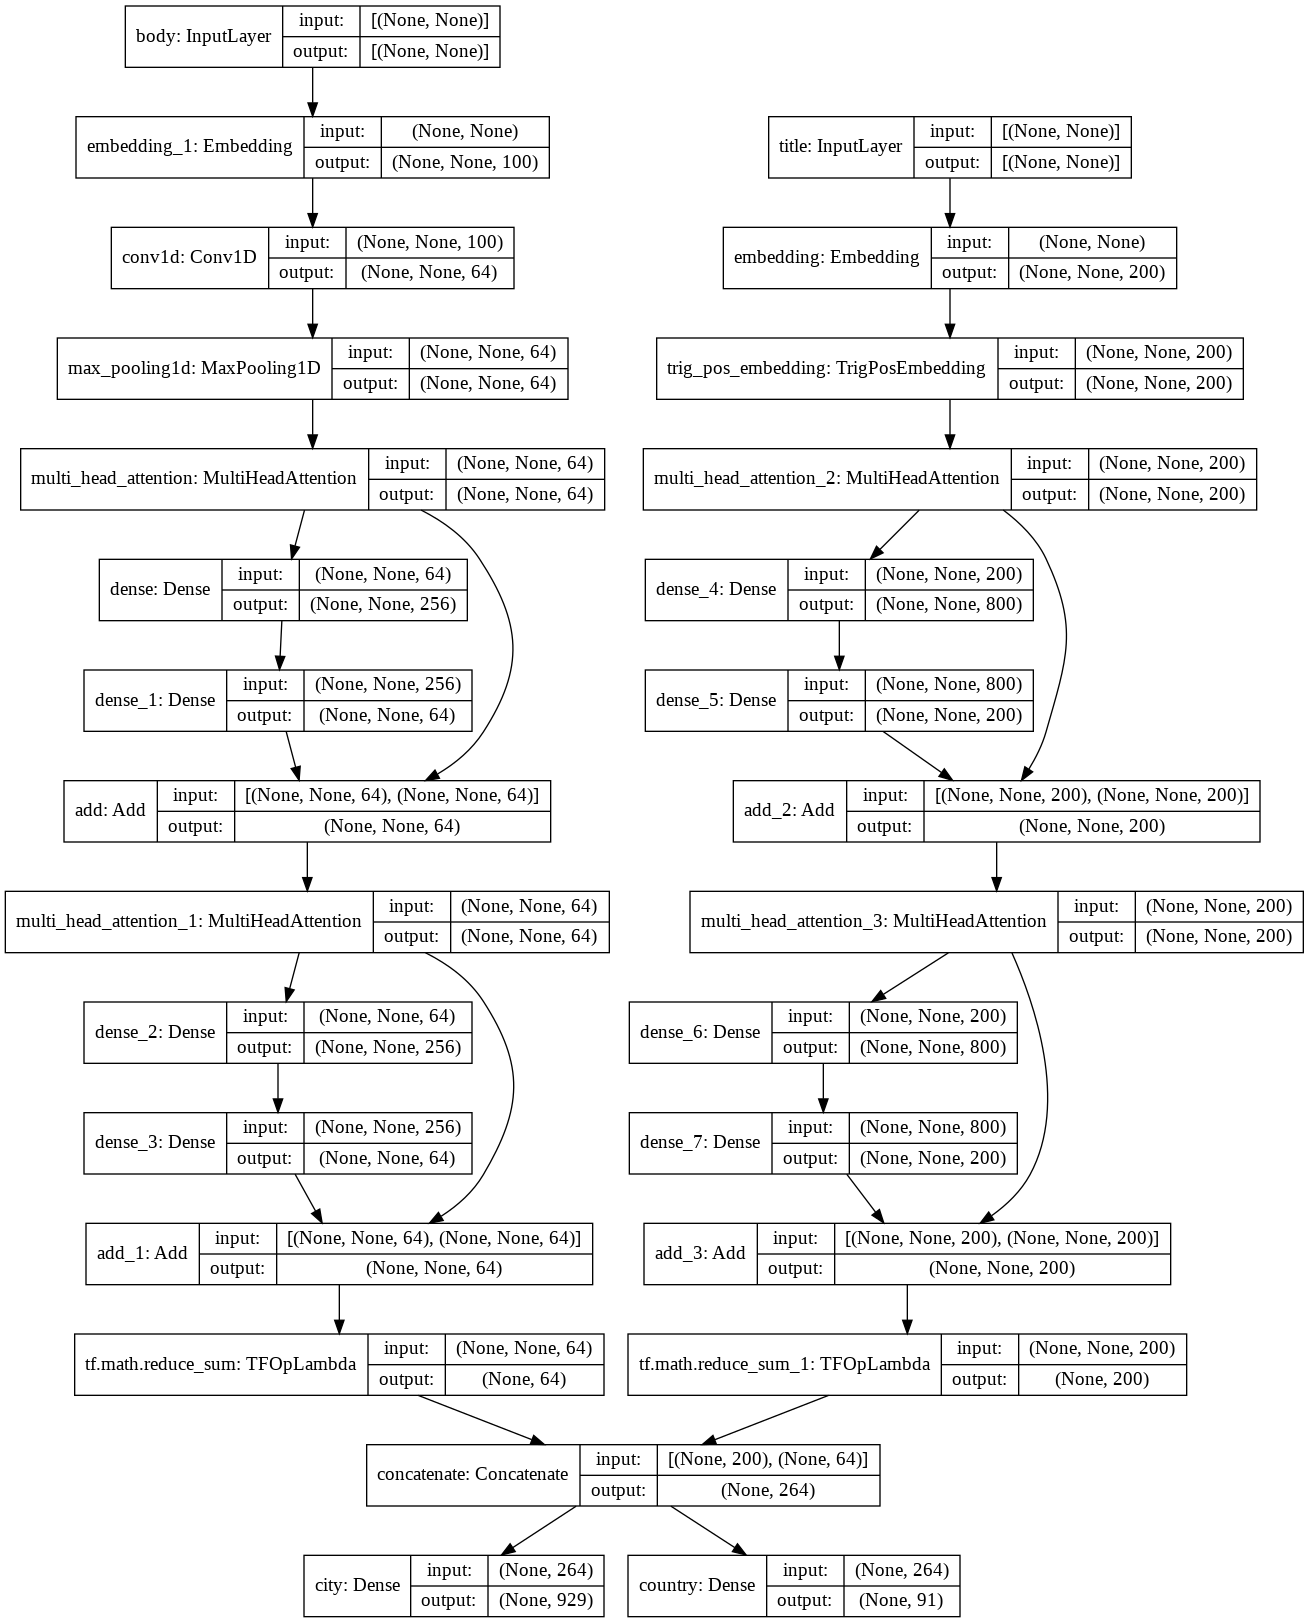

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

implementing character side of model

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(0.0005),
    loss={
        "city": keras.losses.CategoricalCrossentropy(from_logits=True),
        "country": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 1.0],
    metrics = ['accuracy']
)


In [ ]:
print(y_country_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
history = model.fit(
    {"title": x_train,"body":x_char_train},
    {"city": y_train,"country":y_country_train},  # y_train in front of country should be changed 
    epochs=10,
    batch_size=512,
    verbose=1
) 


Epoch 1/10
9/9 [==============================] - 60s 6s/step - loss: 10.5183 - city_loss: 6.8212 - country_loss: 3.6972 - city_accuracy: 5.9911e-04 - country_accuracy: 0.2852
Epoch 2/10
9/9 [==============================] - 55s 6s/step - loss: 9.3022 - city_loss: 6.6413 - country_loss: 2.6609 - city_accuracy: 0.0108 - country_accuracy: 0.3966
Epoch 3/10
9/9 [==============================] - 55s 6s/step - loss: 8.9145 - city_loss: 6.4012 - country_loss: 2.5133 - city_accuracy: 0.0161 - country_accuracy: 0.4047
Epoch 4/10
9/9 [==============================] - 55s 6s/step - loss: 8.8334 - city_loss: 6.2825 - country_loss: 2.5509 - city_accuracy: 0.0212 - country_accuracy: 0.3919
Epoch 5/10
9/9 [==============================] - 55s 6s/step - loss: 8.6867 - city_loss: 6.2446 - country_loss: 2.4421 - city_accuracy: 0.0320 - country_accuracy: 0.4131
Epoch 6/10
9/9 [==============================] - 54s 6s/step - loss: 8.7007 - city_loss: 6.2511 - country_loss: 2.4496 - city_accuracy: 0.0

In [ ]:
# Evaluate the accuracy of our trained model
score = model.evaluate({"title": x_test,"body":x_char_test},
    {"city": y_test,"country": y_country_test}, batch_size=512, verbose=1)
print('Test loss:', score[0])
print('Test city accuracy:', score[3]*100)
print('Test country accuracy:', score[4]*100)

3/3 [==============================] - 5s 1s/step - loss: 8.6956 - city_loss: 6.3579 - country_loss: 2.3377 - city_accuracy: 0.0418 - country_accuracy: 0.4308
Test loss: 8.695621490478516
Test city accuracy: 4.177545756101608
Test country accuracy: 43.08094084262848


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  # plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


print(history.history.keys())

dict_keys(['loss', 'city_loss', 'country_loss', 'city_accuracy', 'country_accuracy'])


dict_keys(['loss', 'city_loss', 'country_loss', 'city_accuracy', 'country_accuracy'])


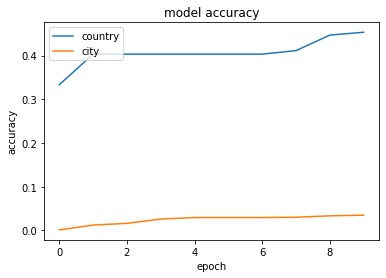

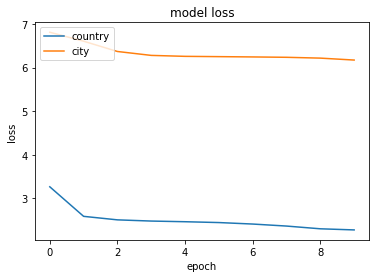

In [ ]:
print(history.history.keys())
plt.plot(history.history['country_accuracy'])
plt.plot(history.history['city_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['country', 'city'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['country_loss'])
plt.plot(history.history['city_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['country', 'city'], loc='upper left')
plt.show()

model2

In [ ]:
#  num_words = 1000

drop = 0.3
word_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
char_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
d = 200    #dimension of a word
# Embed each word in the title into a 64-dimensional vector
word_features = layers.Embedding(1000, d)(word_input)

word_features = TrigPosEmbedding(
    output_dim=d,                      # The dimension of embeddings.
    mode=TrigPosEmbedding.MODE_ADD,  # Use `expand` mode
)(word_features)
# word_features = layers.add([word_features,pos_encoding])
print(word_features.shape)

# CHARS getting character encoding here instead for now only using words
char_features = layers.Embedding(1000, 100)(char_input)
print(char_features.shape, " char features")

#CHARS convolution for characters filters=100 kernel=3
res_conv = tf.keras.layers.Conv1D(64, 3, activation='relu',input_shape=(None,128))(char_features)
print(res_conv.shape, " res conv shape")

#CHARS max pooling layer after conv1D
res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
print(res_pool.shape, " res pool shape")

#CHARS two multihead self-attention folloowed by feed forward neural network
multi = layers.MultiHeadAttention(num_heads=1,key_dim=2) 

char_features = multi(res_pool, res_pool)  # respool used two times for self-attention
print(word_features.shape)
p = 64
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

print(char_features.shape, " char features shape")
multi = layers.MultiHeadAttention(num_heads=1,key_dim=2)
char_features = multi(char_features, char_features)  
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

char_features = tf.reduce_sum(char_features, 1) #converts word matrix to a vector of dimension f 
print(char_features.shape, " char features shape")

#WORDS stack of two multihead self-attention with position-wise feed forward network
multi = layers.MultiHeadAttention(num_heads=1,key_dim=2) 

word_features = multi(word_features, word_features)  
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer

multi = layers.MultiHeadAttention(num_heads=1,key_dim=2) 

word_features = multi(word_features, word_features) 
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer
word_features = tf.reduce_sum(word_features, 1) #converts word matrix to a vector of dimension d  #equation 12

x = layers.concatenate([word_features, char_features]) # concatenate word vector and char vector
print(x.shape," x shape")
dropout = layers.Dropout(drop)(x)
city_pred = layers.Dense(num_classes, name="city",activation="softmax")(x)   #change value of 2 to number of possible cities
# city_pred = tf.keras.layers.Softmax(city_pred)
country_pred = layers.Dense(num_classes_country, name="country",activation="softmax")(x)  #change value of 2 to number of possible countries
# country_pred = tf.keras.layers.Softmax(country_pred)
model = keras.Model(
    inputs=[word_input,char_input],
    outputs=[city_pred, country_pred],
)


(None, None, 200)
(None, None, 100)  char features
(None, None, 64)  res conv shape
(None, None, 64)  res pool shape
(None, None, 200)
(None, None, 64)  char features shape
(None, 64)  char features shape
(None, None, 200)
(None, None, 200)
(None, 264)  x shape


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss={
        "city": keras.losses.CategoricalCrossentropy(from_logits=True),
        "country": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 1.0],
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    {"title": x_train,"body":x_char_train},
    {"city": y_train,"country":y_country_train},  # y_train in front of country should be changed 
    epochs=10,
    batch_size=512,
    verbose=1
) 

In [ ]:
# Evaluate the accuracy of our trained model
score = model.evaluate({"title": x_test,"body":x_char_test},
    {"city": y_test,"country": y_country_test}, batch_size=512, verbose=1)
print('Test loss:', score[0])
print('Test city accuracy:', score[3]*100)
print('Test country accuracy:', score[4]*100)

dict_keys(['loss', 'city_loss', 'country_loss', 'city_accuracy', 'country_accuracy'])


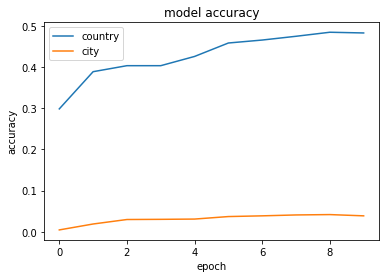

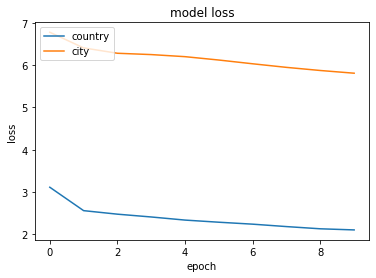

In [ ]:
print(history.history.keys())
plt.plot(history.history['country_accuracy'])
plt.plot(history.history['city_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['country', 'city'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['country_loss'])
plt.plot(history.history['city_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['country', 'city'], loc='upper left')
plt.show()

model3

In [ ]:
#  num_words = 1000

drop = 0.3
word_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
char_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
d = 200    #dimension of a word
# Embed each word in the title into a 64-dimensional vector
word_features = layers.Embedding(1000, d)(word_input)

word_features = TrigPosEmbedding(
    output_dim=d,                      # The dimension of embeddings.
    mode=TrigPosEmbedding.MODE_ADD,  # Use `expand` mode
)(word_features)
# word_features = layers.add([word_features,pos_encoding])
print(word_features.shape)

# CHARS getting character encoding here instead for now only using words
char_features = layers.Embedding(1000, 100)(char_input)
print(char_features.shape, " char features")

#CHARS convolution for characters filters=100 kernel=3
res_conv = tf.keras.layers.Conv1D(64, 3, activation='relu',input_shape=(None,128))(char_features)
print(res_conv.shape, " res conv shape")

#CHARS max pooling layer after conv1D
res_pool = tf.keras.layers.MaxPooling1D(pool_size=3,strides=1, padding='valid')(res_conv)
print(res_pool.shape, " res pool shape")

#CHARS two multihead self-attention folloowed by feed forward neural network
multi = layers.MultiHeadAttention(num_heads=2,key_dim=2) 

char_features = multi(res_pool, res_pool)  # respool used two times for self-attention
print(word_features.shape)
p = 64
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

print(char_features.shape, " char features shape")
multi = layers.MultiHeadAttention(num_heads=2,key_dim=2)
char_features = multi(char_features, char_features)  
char_features1 = layers.Dense(4*p, activation='relu')(char_features) # feed forward network layer1
char_features1 = layers.Dense(p, activation='relu')(char_features1) # feed forward network layer2 
char_features = layers.add([char_features, char_features1])  # residual layer

char_features = tf.reduce_sum(char_features, 1) #converts word matrix to a vector of dimension f 
print(char_features.shape, " char features shape")

#WORDS stack of two multihead self-attention with position-wise feed forward network
multi = layers.MultiHeadAttention(num_heads=2,key_dim=2) 

word_features = multi(word_features, word_features)  
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer

multi = layers.MultiHeadAttention(num_heads=2,key_dim=2) 

word_features = multi(word_features, word_features) 
print(word_features.shape)

word_features1 = layers.Dense(4*d, activation='relu')(word_features) # feed forward network layer1
word_features1 = layers.Dense(d, activation='relu')(word_features1) # feed forward network layer2 
word_features = layers.add([word_features, word_features1])  # residual layer
word_features = tf.reduce_sum(word_features, 1) #converts word matrix to a vector of dimension d  #equation 12

x = layers.concatenate([word_features, char_features]) # concatenate word vector and char vector
print(x.shape," x shape")
dropout = layers.Dropout(drop)(x)
city_pred = layers.Dense(num_classes, name="city",activation="softmax")(x)   #change value of 2 to number of possible cities
# city_pred = tf.keras.layers.Softmax(city_pred)
country_pred = layers.Dense(num_classes_country, name="country",activation="softmax")(x)  #change value of 2 to number of possible countries
# country_pred = tf.keras.layers.Softmax(country_pred)
model = keras.Model(
    inputs=[word_input,char_input],
    outputs=[city_pred, country_pred],
)


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss={
        "city": keras.losses.CategoricalCrossentropy(from_logits=True),
        "country": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 1.0],
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    {"title": x_train,"body":x_char_train},
    {"city": y_train,"country":y_country_train},  # y_train in front of country should be changed 
    epochs=10,
    batch_size=512,
    verbose=1
) 

Epoch 1/10
9/9 [==============================] - 32s 3s/step - loss: 10.3397 - city_loss: 6.8205 - country_loss: 3.5192 - city_accuracy: 0.0021 - country_accuracy: 0.2443
Epoch 2/10
9/9 [==============================] - 29s 3s/step - loss: 9.0776 - city_loss: 6.4464 - country_loss: 2.6313 - city_accuracy: 0.0128 - country_accuracy: 0.3871
Epoch 3/10
9/9 [==============================] - 29s 3s/step - loss: 8.7758 - city_loss: 6.2488 - country_loss: 2.5270 - city_accuracy: 0.0313 - country_accuracy: 0.3976
Epoch 4/10
9/9 [==============================] - 29s 3s/step - loss: 8.6846 - city_loss: 6.2590 - country_loss: 2.4256 - city_accuracy: 0.0305 - country_accuracy: 0.3997
Epoch 5/10
9/9 [==============================] - 29s 3s/step - loss: 8.5724 - city_loss: 6.2340 - country_loss: 2.3384 - city_accuracy: 0.0300 - country_accuracy: 0.4275
Epoch 6/10
9/9 [==============================] - 29s 3s/step - loss: 8.4367 - city_loss: 6.1471 - country_loss: 2.2895 - city_accuracy: 0.0347 

In [ ]:
# Evaluate the accuracy of our trained model
score = model.evaluate({"title": x_test,"body":x_char_test},
    {"city": y_test,"country": y_country_test}, batch_size=512, verbose=1)
print('Test loss:', score[0])
print('Test city accuracy:', score[3]*100)
print('Test country accuracy:', score[4]*100)

3/3 [==============================] - 3s 628ms/step - loss: 8.4845 - city_loss: 6.2594 - country_loss: 2.2251 - city_accuracy: 0.0383 - country_accuracy: 0.4674
Test loss: 8.484492301940918
Test city accuracy: 3.8294170051813126
Test country accuracy: 46.73629105091095


dict_keys(['loss', 'city_loss', 'country_loss', 'city_accuracy', 'country_accuracy'])


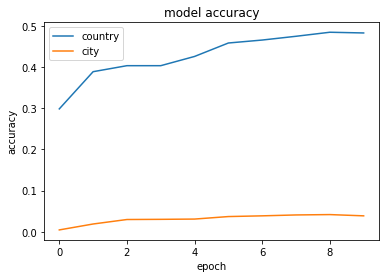

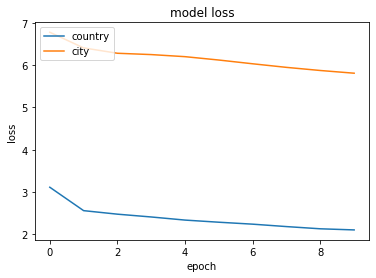

In [ ]:
print(history.history.keys())
plt.plot(history.history['country_accuracy'])
plt.plot(history.history['city_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['country', 'city'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['country_loss'])
plt.plot(history.history['city_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['country', 'city'], loc='upper left')
plt.show()